# Прогнозирование успешного выполнения элементов фигурного катания

Жуков Игорь
[@Igor_A_Zhukov](https://t.me/Igor_A_Zhukov/), Москва 2024 г.

**Заказчик:**

 - Компания [GoProtect](https://www.goprotect.ru/)

# Описание задачи

- Сервис  **Мой Чемпион** помогает спортивным школам фигурного катания и тренерам мониторить результаты своих подопечных и планировать дальнейшее развитие спортсменов.

**Цель**
- Создать модель, помогающую находить элементы, которые могут быть успешно исполнены спортсменом на соревновании, прогноз нужно делать для спортсменов - одиночников

**Задача**
- Поскольку выявлена невозможность выделения стоимости каждого элемента из общей стоиости последовательности, принято решение нахождения **вероятности успешного исполнения каждого элемента**. 
- Задача будет решена **частично** - модель будет предсказывать только **вероятности исполнения тройных прыжков**
- Для получения предсказаний по **другим группам** элементов необходимо будет впоследствии создать дополнительные модели, аналогичные имеющимся на базе того-же датасета, но с другим набором **целевых признаков**

**План действий**
- Объединить данные – спортсмены, юниты, соревнования, сегменты, школы, тренеры
- Провести анализ данных, изучить аномалии, корреляции, описать наблюдения и сделать выводы
- Выделить все элементы фигурного катания, представленых в виде объединенной строки например `2F!<<+2Lo<<CCoSp2V*`
- Выделить элементы успешно выполненные и с погрешностями (имеют специальные пометки)
---
- Агрегировать датасет и подготовить обучающие признаки
---
- Создать модель для предсказания **вероятности успешного выполнения элементов**
- Проанализировать признаки, выявить ошибки и слабые стороны модели
---
- Дать предложения по улучшению модели

### Описание исходных данных:
Данные представлены в четырех файлах:
- файл **`units.csv`** - описание спортсмена
    - `id`: идентификатор спортсмена (юнита - в нашем случае, поскольку анализируются спортсмены-одиночники, юнит - это один спортсмен)
    - `color`: категория спортсмена
    - `school_id`: идентификатор школы
---
- файл **`total_scores.csv`** - оценки по категориям
    - `id`: идентификатор турнира
    - `date_start`: дата начала
    - `date_end`: дата завершения
    - `origin_id`: место проведения
---
- файл **`tournaments.csv`** - оценки за выступления по категориям и общие за турнир
    - `id`: идентификатор выступления, внешний ключ с tournament_scores.total_score_id
    - `unit_id`: идентификатор юнита, ключ к units.id
    - `tournament_id`: идентификатор турнира, tournaments.id
    - `components_score`: артистизм (мастерство, композиция, хореография)
    - `base_score`: базовая оценка за элементы в выступлении (идеал)
    - `elements_score`: реальная оценка всех выполненных элементов, base_score+goe
    - `decreasings_score`: снижения оценок за ошибки
    - `total_score`: components_score+elements_score+decreasings_score за выступление
    - `starting_place`:
    - `place`: занятое место в категории category_name+segment_name
    - `segment_name`: название сегмента
    - `info`: комментарии и пояснения к оценке
    - `overall_place`: итоговое место в турнире
    - `overall_total_score`: итоговая оценка за весь турнир
    - `overall_place_str`: комментарии, пояснения
---
- файл **`tournament_scores.csv`** - таблица с оценками поэлементно
    - `id`: идентификатор оценки за конкретный элемент/комбинацию
    - `total_score_id`: идентикатор выступления, ключ total_scores.id
    - `title`: запись элемента или комбинации элементов с отметками об ошибках
    - `decrease`: за что снижена оценка
    - `base_score`: базовая оценка (идеал, цена данного элемента/комбинации, сложность)
    - `goe`: Grade of Execute, качество исполнения, судейские надбавки/убавки
    - `avg_score`: оценка за элемент/комбинацию (усредненная по судьям)


## Загрузим необходимые библиотеки и осуществим настройки вывода

### Загрузим библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder)

from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.dummy import DummyRegressor

from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     cross_validate)

from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             r2_score,
                             get_scorer_names)

from sklearn.impute import KNNImputer, SimpleImputer

from imblearn.pipeline import Pipeline, make_pipeline

from optuna.integration import OptunaSearchCV
from optuna.distributions import (FloatDistribution,
                                  IntDistribution,
                                  CategoricalDistribution)

import re
import os
import phik
import copy

### Настроим вывод данных на экран

In [2]:
#pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

### Определим значения констант для сопоставимости результатов разных отделов

In [3]:
RANDOM_STATE = 53
TEST_SIZE = 0.25

## Загрузим и изучим данные

### Объявим функцию загрузки
с проверкой загрузки, заданием индекса и приведением наименований столбцов к общепринятому виду

In [4]:
def loader(path):
    loaded_data=[]
    if os.path.exists(path):
        loaded_data = pd.read_csv(path) #, index_col=[0])
        print('Загружен файл: ', path)
        
        loaded_data.columns = [re.sub(r'(?<!^)(?=[A-Z])',
                '_', i).lower() for i in loaded_data.columns]
        
    else:
        print('Проверьте путь')
    
    return loaded_data

#### Загрузим данные

In [5]:
path_units = 'units.csv'
path_total_scores = 'total_scores.csv'
path_tournaments = 'tournaments.csv'
path_tournament_scores = 'tournament_scores.csv'

In [6]:
units = loader(path_units)
total_scores = loader(path_total_scores)
tournaments = loader(path_tournaments)
tournament_scores = loader(path_tournament_scores)

Загружен файл:  units.csv
Загружен файл:  total_scores.csv
Загружен файл:  tournaments.csv
Загружен файл:  tournament_scores.csv


### Объявим функцию description для первичного исследования данных

In [7]:
def description(data):

    '''Функция принимает на входе датасет и выводит для исследуемого датасета:
    - описание info(),
    - первые две и последние две строки,
    - количество полных дубликатов,
    - количество пропущенных значений,
    - количество уникальных индексов,
    - статистические характеристики датасета,
    - первые 5 и последние 5 уникальных элементов каждого столбца
    '''
    print('\033[1m \nОбщая информация: \n\033[0m \n')
    data.info()
    display(data.head(2))
    display(data.tail(2))

    print('\n\033[1m Количество дубликатов: \033[0m', data.duplicated().sum())
    print('\033[1m Пропущенных значений: \033[0m', data.isna().sum().sum())
    print('\033[1m Уникальных индексов: \033[0m', data.index.nunique())
    print('\n\033[1m  Статистические характеристики датасета: \033[0m')

    display(data.describe(include = 'all', datetime_is_numeric=True).T)

    print('\033[1m \nИзучим 5 минимальных и 5 максимальных значений каждого столбца: \033[0m \n')
    for column in data.columns:
        try:
            print(column, 'Уникальных значений:', data[column].nunique())
            print(sorted(data[data[column].notna()][column].unique())[0:5], '.....',
                  sorted(data[data[column].notna()][column].unique())[-5:-1],
                  sorted(data[data[column].notna()][column].unique())[-1], '\n')
        except:
            print('не может быть показана - пропуски или ошибка')


### Изучим имеющиеся данные

#### Изучим датасет `units`

In [8]:
description(units)

 
Общая информация: 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4596 non-null   int64  
 1   color      4595 non-null   object 
 2   school_id  4007 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 107.8+ KB


,id,color,school_id
0,9474,green,244.0
1,733,green,203.0


,id,color,school_id
4594,5110,green,62.0
4595,5113,green,62.0



 Количество дубликатов:  0
 Пропущенных значений:  590
 Уникальных индексов:  4596

  Статистические характеристики датасета: 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,4596.0,NaN,NaN,NaN,5016.516971,7355.726664,1.0,1476.75,2953.5,4615.25,35024.0
color,4595,2,green,3800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
school_id,4007.0,NaN,NaN,NaN,464.135762,5679.988355,1.0,62.0,117.0,206.0,99999.0


 
Изучим 5 минимальных и 5 максимальных значений каждого столбца:  

id Уникальных значений: 4596
[1, 3, 4, 5, 6] ..... [35020, 35021, 35022, 35023] 35024 

color Уникальных значений: 2
['green', 'lime'] ..... ['green'] lime 

school_id Уникальных значений: 239
[1.0, 2.0, 3.0, 4.0, 5.0] ..... [289.0, 293.0, 302.0, 305.0] 99999.0 



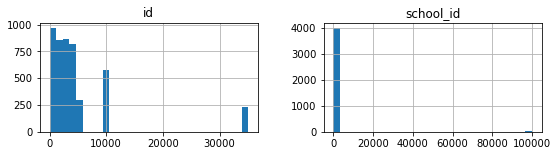

In [9]:
units.hist(figsize = (9, 2), bins = 30);

In [10]:
(units['school_id'] > 1000).sum()

13

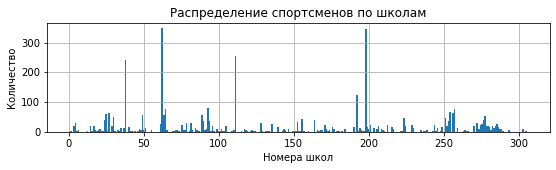

In [11]:
plt.figure(figsize = (9, 2))
units[units['school_id'] < 1000]['school_id'].plot(kind = 'hist', grid = True,
                        bins = 300, title = 'Распределение спортсменов по школам')
plt.ylabel('Количество')
plt.xlabel('Номера школ');

In [12]:
units['school_id'].value_counts().head(6)

62.0     348
198.0    345
111.0    255
38.0     241
192.0    124
93.0      80
Name: school_id, dtype: int64

- в датасете **3** столбца с признаками
- в датасете **4596** объектов
- полные дубликаты **отсутствуют** 
- **все** идентификаторы спортсменов **уникальны**
- наибольшее количество спортсменов обучаются в школах 62 и 198
---
- столбец `school_id` имеет неверный тип `float64` из-за пропусков в данных
- имеется **590** пропущенных значений, из них **589** в признаке `school_id`, и один - в признаке `color`
- в признаке `school_id` имеется 13 недостоверных значений **99999** (остальные идентификаторы трехзначные, количество уникальных школ **239**, предыдущее максимальное значение 305), возможно это обозначение, что школа неизвестна, предлагается все пропуски заполнить этим значением
---
- пропуск в `color` предлагается заполнить самым частым значением **green**
- метод заполнения пропусков в `school_id` предлагается выбрать на основе более детального анализа

#### Изучим датасет `total_scores`

In [13]:
description(total_scores)

 
Общая информация: 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21284 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14  overall_place_str    10814 non-null  object 
dtypes: float64(6

,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
0,442027,304,4785,47.2,43.47,102.70,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2
1,442028,604,4785,45.4,46.71,101.19,54.48,0.0,18,2,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,1,294.75,1


,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
21299,462408,34980,7116,21.17,26.0,45.24,20.74,-1.5,2,23,Произвольная программа,q Прыжок приземлён в четверть < Недокрученный ...,24,68.22,24
21300,462409,9973,7116,18.91,25.0,43.05,18.55,-0.5,8,24,Произвольная программа,* Недопустимый элемент ! Неясное ребро на толч...,23,68.84,23



 Количество дубликатов:  0
 Пропущенных значений:  11102
 Уникальных индексов:  21301

  Статистические характеристики датасета: 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,21301.0,NaN,NaN,NaN,247946.268156,218940.086177,1.0,9835.0,442628.0,450362.0,463639.0
unit_id,21301.0,NaN,NaN,NaN,2342.803859,4370.220096,1.0,418.0,1233.0,2217.0,35024.0
tournament_id,21301.0,NaN,NaN,NaN,3146.281254,3279.412969,1.0,49.0,267.0,6859.0,7117.0
base_score,21301.0,NaN,NaN,NaN,27.809781,16.337113,0.0,15.56,24.49,35.11,94.42
components_score,21301.0,NaN,NaN,NaN,31.324416,17.330241,0.0,20.42,26.66,41.6,95.9
total_score,21301.0,NaN,NaN,NaN,60.410021,33.598123,0.0,35.88,52.63,75.72,201.65
elements_score,21301.0,NaN,NaN,NaN,27.836501,17.745763,0.0,14.88,24.27,35.91,112.42
decreasings_score,21301.0,NaN,NaN,NaN,-0.240998,0.577598,-7.0,0.0,0.0,0.0,0.0
starting_place,21301.0,NaN,NaN,NaN,10.962819,8.352286,0.0,5.0,9.0,15.0,54.0
place,21301.0,NaN,NaN,NaN,10.619924,8.06279,0.0,4.0,9.0,15.0,50.0


 
Изучим 5 минимальных и 5 максимальных значений каждого столбца:  

id Уникальных значений: 21301
[1, 8, 19, 26, 38] ..... [463635, 463636, 463637, 463638] 463639 

unit_id Уникальных значений: 3393
[1, 3, 4, 5, 6] ..... [35003, 35004, 35005, 35006] 35024 

tournament_id Уникальных значений: 142
[1, 2, 3, 4, 5] ..... [7112, 7114, 7115, 7116] 7117 

base_score Уникальных значений: 5454
[0.0, 0.9, 1.0, 1.2, 1.4] ..... [89.78, 90.1, 91.57, 93.37] 94.42 

components_score Уникальных значений: 3926
[0.0, 5.38, 5.88, 6.0, 6.38] ..... [94.42, 94.75, 95.07, 95.74] 95.9 

total_score Уникальных значений: 9575
[0.0, 1.8, 2.68, 2.8, 3.56] ..... [195.98, 196.01, 199.54, 200.58] 201.65 

elements_score Уникальных значений: 6191
[0.0, 0.9, 1.0, 1.06, 1.17] ..... [104.15, 105.4, 106.58, 107.23] 112.42 

decreasings_score Уникальных значений: 12
[-7.0, -6.0, -5.0, -4.0, -3.5] ..... [-2.0, -1.5, -1.0, -0.5] 0.0 

starting_place Уникальных значений: 55
[0, 1, 2, 3, 4] ..... [50, 51, 52, 53] 54 

place 

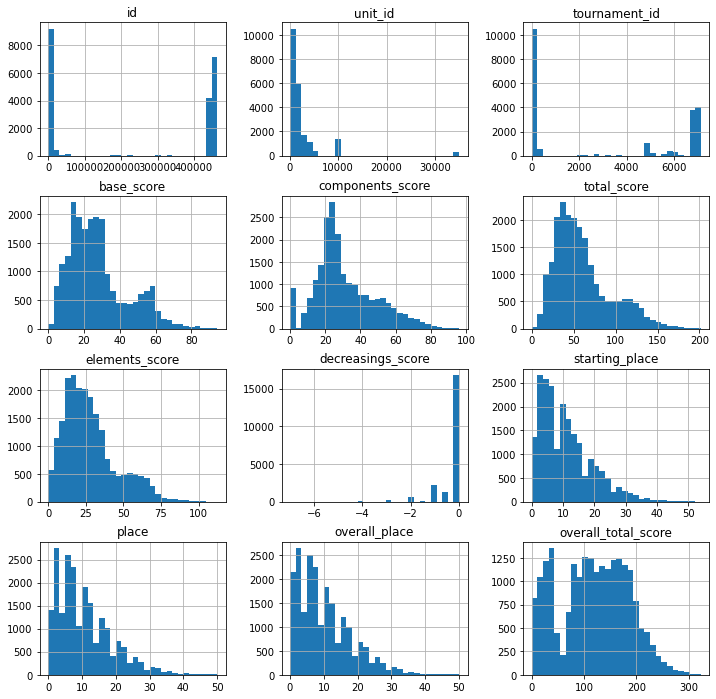

In [14]:
total_scores.hist(figsize = (12, 12), bins = 30);

- в датасете **15** столбцов с признаками
- в датасете **21301** объект
- полные дубликаты **отсутствуют** 
- **все** идентификаторы счетов **уникальны**
---
- имеется **11102** пропущенных значений, в основном в признаке `overall_place_str`, и в `info`, в случае необходимости предлагается заполнить значением `нет`
---
- анализ счета выявил **многочисленные расхождения** между указанными значениями оценок и значением, полученным в результате арифметической проверки

#### Изучим датасет `tournaments`

In [15]:
description(tournaments)

 
Общая информация: 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          142 non-null    int64  
 1   date_start  142 non-null    object 
 2   date_end    142 non-null    object 
 3   origin_id   142 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ KB


,id,date_start,date_end,origin_id
0,1,2090-11-29,2090-12-01,2.0
1,2,2091-03-06,2091-03-10,1.0


,id,date_start,date_end,origin_id
140,7115,2092-04-23,2092-04-26,2.0
141,6676,2092-02-28,2092-03-01,1.0



 Количество дубликатов:  0
 Пропущенных значений:  0
 Уникальных индексов:  142

  Статистические характеристики датасета: 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,142.0,NaN,NaN,NaN,2671.232394,3129.148777,1.0,38.25,93.5,6692.5,7117.0
date_start,142,127,2091-01-26,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_end,142,126,2091-02-03,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
origin_id,142.0,NaN,NaN,NaN,1.380282,0.760108,0.0,1.0,2.0,2.0,2.0


 
Изучим 5 минимальных и 5 максимальных значений каждого столбца:  

id Уникальных значений: 142
[1, 2, 3, 4, 5] ..... [7112, 7114, 7115, 7116] 7117 

date_start Уникальных значений: 127
['2089-09-20', '2089-10-05', '2089-10-07', '2090-02-15', '2090-03-28'] ..... ['2092-04-11', '2092-04-14', '2092-04-15', '2092-04-23'] 2092-04-29 

date_end Уникальных значений: 126
['2089-09-23', '2089-10-06', '2089-10-08', '2090-02-18', '2090-03-30'] ..... ['2092-04-13', '2092-04-16', '2092-04-20', '2092-04-26'] 2092-05-03 

origin_id Уникальных значений: 3
[0.0, 1.0, 2.0] ..... [0.0, 1.0] 2.0 



- переведем столбцы с датами в формат `datetime`

In [16]:
tournaments['date_start'] = pd.to_datetime(tournaments['date_start'])
tournaments['date_end'] = pd.to_datetime(tournaments['date_end'])

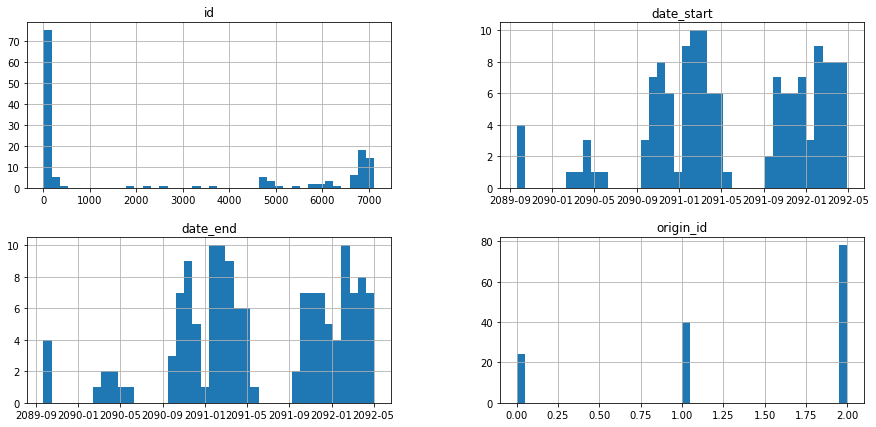

In [17]:
tournaments.hist(figsize = (15, 7), bins = 40);

In [18]:
tournaments.sort_values(by = 'id')[96:117].head(5)

,id,date_start,date_end,origin_id
95,5859,2092-02-02,2092-02-04,2.0
96,5860,2092-02-02,2092-02-04,2.0
117,5879,2092-01-29,2092-02-02,1.0
116,5883,2092-01-27,2092-01-28,1.0
97,6150,2092-02-06,2092-02-08,2.0


- в датасете **4** столбца с признаками
- в датасете **142** объекта - 142 турнира
- полные дубликаты **отсутствуют** 
- **все** идентификаторы счетов **уникальны**
---
- столбцы с датами имели неверный тип `object`, требуется приведение к `datetime` для создания календарных признаков
- пропущенные значения **отсутствуют**

 - номера турниров не всегда идут по возрастанию даты турниров, возможно потребуется учесть данный факт при создании обучающей выборки

#### Изучим датасет `tournament_scores`

In [19]:
description(tournament_scores)

 
Общая информация: 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              172158 non-null  int64  
 1   total_score_id  172158 non-null  int64  
 2   title           172158 non-null  object 
 3   decrease        41185 non-null   object 
 4   base_score      172158 non-null  float64
 5   goe             172158 non-null  float64
 6   avg_score       172158 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 9.2+ MB


,id,total_score_id,title,decrease,base_score,goe,avg_score
0,1,1,2A,NaN,3.3,0.66,3.96
1,2,1,3F+3Lo,NaN,10.2,-0.11,10.09


,id,total_score_id,title,decrease,base_score,goe,avg_score
172156,352011,463407,StSq2,NaN,2.6,0.52,3.12
172157,352012,463407,FSSp3,NaN,2.6,0.26,2.86



 Количество дубликатов:  0
 Пропущенных значений:  130973
 Уникальных индексов:  172158

  Статистические характеристики датасета: 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,172158.0,NaN,NaN,NaN,148848.485444,107651.944104,1.0,50613.25,158772.5,223563.75,353806.0
total_score_id,172158.0,NaN,NaN,NaN,243100.514156,219065.848493,1.0,9385.0,442337.0,449883.75,463639.0
title,172158,3425,CCoSp4,8687,NaN,NaN,NaN,NaN,NaN,NaN,NaN
decrease,41185,32,<,10469,NaN,NaN,NaN,NaN,NaN,NaN,NaN
base_score,172158.0,NaN,NaN,NaN,2.5743,2.151716,0.0,1.1,2.6,3.3,15.7
goe,172158.0,NaN,NaN,NaN,0.131771,0.797761,-5.75,-0.12,0.21,0.6,5.06
avg_score,172158.0,NaN,NaN,NaN,3.567541,2.424646,0.0,1.98,3.25,4.2,23.36


 
Изучим 5 минимальных и 5 максимальных значений каждого столбца:  

id Уникальных значений: 172158
[1, 2, 3, 4, 5] ..... [353802, 353803, 353804, 353805] 353806 

total_score_id Уникальных значений: 21301
[1, 8, 19, 26, 38] ..... [463635, 463636, 463637, 463638] 463639 

title Уникальных значений: 3425
['1A', '1A*', '1A*+1Eu+2S', '1A*+1Lo*', '1A*+1Lo*+REP'] ..... ['StSq4', 'StSqB', 'T', 'USpB'] USpB* 

decrease Уникальных значений: 32
['!', '!*', '!<', '!F', '!F*'] ..... ['nU', 'q', 'q*', 'qF'] В 

base_score Уникальных значений: 376
[0.0, 0.28, 0.32, 0.34, 0.35] ..... [14.6, 14.7, 14.8, 15.2] 15.7 

goe Уникальных значений: 599
[-5.75, -5.5, -5.29, -5.25, -4.85] ..... [4.4, 4.56, 4.6, 4.83] 5.06 

avg_score Уникальных значений: 1552
[0.0, 0.08, 0.1, 0.11, 0.12] ..... [19.73, 20.3, 22.54, 23.13] 23.36 



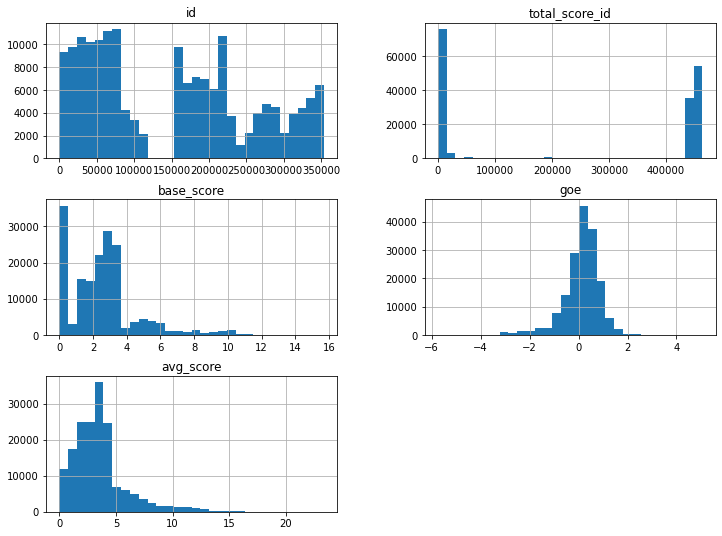

In [20]:
tournament_scores.hist(figsize = (12, 9), bins = 30);

- в датасете **7** столбцов с оценками за элементы программы на выступлениях
- в датасете **172158** объектов - это **основной датасет** для сбора общего датасета для обучения
- полные дубликаты **отсутствуют** 
- **все** идентификаторы записей **уникальны**
---
- в столбце `decrease` 130973 пропущенных значений, которые означают **отсутствие** погрешностей при исполнении элемента (последовательности элементов), предлагется заполнить словом `нет`

### Выводы по результатам первичного анализа данных

- сводный датасет необходимо собирать на основании датасета `tournament_scores`, как имеющего наибольшее количество значений и информацию для создания целевого признака

## Создадим сводный датасет

In [21]:
data = tournament_scores.join(total_scores.set_index('id'), on='total_score_id',
                                                            rsuffix='_')
data = data.join(tournaments.set_index('id'), on='tournament_id')
data = data.join(units.set_index('id'), on='unit_id')

In [22]:
data.shape

(172158, 26)

In [23]:
data.tail(2)

,id,total_score_id,title,decrease,base_score,goe,avg_score,unit_id,tournament_id,base_score_,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str,date_start,date_end,origin_id,color,school_id
172156,352011,463407,StSq2,NaN,2.6,0.52,3.12,9969,7117,20.0,26.55,48.9,22.35,0.0,10,2,Произвольная программа.,NaN,0,0.0,NaN,2092-04-29,2092-05-03,0.0,green,105.0
172157,352012,463407,FSSp3,NaN,2.6,0.26,2.86,9969,7117,20.0,26.55,48.9,22.35,0.0,10,2,Произвольная программа.,NaN,0,0.0,NaN,2092-04-29,2092-05-03,0.0,green,105.0


- На базе датасета `tournament_scores` создан сводный датасет `data`, содержащий информацию всех предыдущих датасетов

## Проведем предварительную обработку данных и создадим выборку для обучения и тестирования модели

#### Заполним пропуски в `school_id` значением `99999`
- это значение есть в столбце, оно не соответствует остальным значениями и предположительно означает, что школа не известна

In [24]:
data['school_id'].fillna(data['school_id'].max(), inplace = True)

#### Переведем столбец `date_end` в формат `datetime` и создадим на его основе признак давности `maturity`

In [25]:
data['date_end'] = pd.to_datetime(data['date_end'])

In [26]:
data['date_end'].max()

Timestamp('2092-05-03 00:00:00')

In [27]:
data['maturity'] = data['date_end'].max() - data['date_end']

In [28]:
data['maturity'] = round((data['maturity'].view('int64')
                       / 3600/24/10e8), 0).astype('int64')

#### Удалим ненужные столбцы
- В результате анализа данных выявлены расхождения в указанных в датасете группах оценок и результатом их арифметического сложения, данные недостоверны. 
- Выявлена невозможность выделить стоимость каждого элемента из последовательности элементов, так как оценки даются за всю последовательность.
- Даты соревнований заменены на календарный признак длительности выступления.

In [29]:
useful_columns = ['unit_id', 'origin_id', 'school_id', 'color', 'maturity', 
                  'starting_place', 'title']

In [30]:
data = data[useful_columns]

#### Закодируем признак `color` с помощью `OrdinalEncoder`

In [31]:
ord_enc = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)

In [32]:
data[['color']] = ord_enc.fit_transform(data[['color']])

#### Приведем признаки `origin_id`, `school_id` и `color` к целочисленному типу для красоты

In [33]:
data[['origin_id', 'school_id', 'color']] = data[['origin_id', 'school_id', 'color']].astype('int64')

In [34]:
data.tail(2)

,unit_id,origin_id,school_id,color,maturity,starting_place,title
172156,9969,0,105,0,0,10,StSq2
172157,9969,0,105,0,0,10,FSSp3


- столбцы `origin_id`, `school_id` и `color` приведены к **целочисленному** типу

#### Выделим из `data` выборку с чистыми элементами, без комбинаций, а также выборку с комбинациями

In [35]:
data_elements = data[~data['title'].str.contains('\+')].copy(deep = True)

In [36]:
data_combinations = data[data['title'].str.contains('\+')].copy(deep = True)

In [37]:
data_elements.head(2)

,unit_id,origin_id,school_id,color,maturity,starting_place,title
0,1,2,198,0,519,2,2A
2,1,2,198,0,519,2,3Lz


In [38]:
data_combinations.head(2)

,unit_id,origin_id,school_id,color,maturity,starting_place,title
1,1,2,198,0,519,2,3F+3Lo
9,1,2,198,0,519,2,3Fq+3Loq


#### Объявим фунцию, которая чистит комментарии в каскадах, но оставляет ошибки в элементах

In [39]:
'SЕQ' == 'SEQ'

False

- используются **разные** `E`, нужно учесть при обработке

In [40]:
def clear_comments(text):

    text = re.sub(r'\+COMBO', '', text)
    text = re.sub(r'\+REP', '', text)
    text = re.sub(r'\+SЕQ', '', text) 
    text = re.sub(r'\+SEQ', '', text) # Иногда используется другая Е

    return text

In [41]:
data_combinations['cleared_cascade'] = data_combinations['title'].apply(clear_comments)

In [42]:
data_combinations.tail(2)

,unit_id,origin_id,school_id,color,maturity,starting_place,title,cleared_cascade
172151,9969,0,105,0,0,10,2Lz+2T,2Lz+2T
172152,9969,0,105,0,0,10,2Lo+1A+SЕQ,2Lo+1A


### Выделим из `data_combinations` элементы комбинаций

#### Объявим функцию для разделения элементов в каскаде

In [43]:
def combo_separation(text, element_number = None):
    result = ['', '', '', '']
    result[3] = text[text.rfind('+'):] if '+' in text else text
    text =   text[:text.rfind('+')] if '+' in text else text
    
    result[2] = text[text.rfind('+'):] if '+' in text else text
    text =   text[:text.rfind('+')] if '+' in text else text
    
    result[1] = text[text.rfind('+'):] if '+' in text else text
    result[0] = text[:text.rfind('+')] if '+' in text else ''
    result = [re.sub(r'\+', '', i) for i in result]
        
    if element_number == None:
        return result
    else:
        return result[element_number]

#### Проверим работу функции

In [44]:
combo_separation('A+2T', 1)

'A'

In [45]:
combo_separation('Lz+Eu+3S+DDD')

['Lz', 'Eu', '3S', 'DDD']

In [46]:
combo_separation('Lz+Eu+3S')

['', 'Lz', 'Eu', '3S']

In [47]:
combo_separation('Lz+Eu+3S', 2)

'Eu'

In [48]:
data_combinations['el_1'] = data_combinations['cleared_cascade'].apply(combo_separation, element_number = 0)

data_combinations['el_2'] = data_combinations['cleared_cascade'].apply(combo_separation, element_number = 1)

data_combinations['el_3'] = data_combinations['cleared_cascade'].apply(combo_separation, element_number = 2)

data_combinations['el_4'] = data_combinations['cleared_cascade'].apply(combo_separation, element_number = 3)

#### Удалим ненужные теперь столбцы `title` и `cleared_cascade`

In [49]:
data_combinations.drop(['title', 'cleared_cascade'], axis = 1, inplace = True)

In [50]:
data_combinations.head(2)

,unit_id,origin_id,school_id,color,maturity,starting_place,el_1,el_2,el_3,el_4
1,1,2,198,0,519,2,,3F,3F,3Lo
9,1,2,198,0,519,2,,3Fq,3Fq,3Loq


#### Создадим 4 датасета с о столбцом с элементами, объединенными в последовательности, каждый по порядку - в свой датасет

In [51]:
data_combinations_1 = data_combinations.drop(['el_2', 'el_3', 'el_4'], axis = 1)
data_combinations_1.rename(columns={'el_1': 'title'}, inplace = True)

In [52]:
data_combinations_2 = data_combinations.drop(['el_1', 'el_3', 'el_4'], axis = 1)
data_combinations_2.rename(columns={'el_2': 'title'}, inplace = True)

In [53]:
data_combinations_3 = data_combinations.drop(['el_1', 'el_2', 'el_4'], axis = 1)
data_combinations_3.rename(columns={'el_3': 'title'}, inplace = True)

In [54]:
data_combinations_4 = data_combinations.drop(['el_1', 'el_2', 'el_3'], axis = 1)
data_combinations_4.rename(columns={'el_4': 'title'}, inplace = True)

In [55]:
data_combinations_1.head(3).tail(1)

,unit_id,origin_id,school_id,color,maturity,starting_place,title
10,1,2,198,0,519,2,


In [56]:
data_combinations_2.head(3).tail(1)

,unit_id,origin_id,school_id,color,maturity,starting_place,title
10,1,2,198,0,519,2,3Lz<


In [57]:
data_combinations_3.head(3).tail(1)

,unit_id,origin_id,school_id,color,maturity,starting_place,title
10,1,2,198,0,519,2,1Eu


In [58]:
data_combinations_4.head(3).tail(1)

,unit_id,origin_id,school_id,color,maturity,starting_place,title
10,1,2,198,0,519,2,2F


#### Присоединим столбцы с выделенными из последовательностей элементами к датафрейму `data_elements`

In [59]:
data_elements = pd.concat((data_elements, 
                           data_combinations_1,
                           data_combinations_2,
                           data_combinations_3,
                           data_combinations_4),
                           ignore_index = True,
                           axis = 0).reset_index(drop = True)

#### Удалим строки с пустыми элементами 

In [60]:
data_elements[data_elements['title'] == ''].count()

unit_id           37221
origin_id         37221
school_id         37221
color             37221
maturity          37221
starting_place    37221
title             37221
dtype: int64

In [61]:
data_elements = data_elements[data_elements['title'] != ''].reset_index(drop = True)

In [62]:
data_elements.tail()

,unit_id,origin_id,school_id,color,maturity,starting_place,title
246619,4084,0,198,1,0,7,1A*
246620,231,0,111,0,0,9,1A
246621,231,0,111,0,0,9,2Lo
246622,9969,0,105,0,0,10,2T
246623,9969,0,105,0,0,10,1A


#### Объявим фунцию, которая находит элементы без ошибок

In [63]:
def find_good_elements(text):
    
    vocab = ['<', '!', '*', 'V']
    vocab_2 = ['e', 'q']
    mistake = 1
    for item in vocab:
        if item in text:
            mistake = 0
    
    if ('e' in text) and ('StSe' not in text):
        mistake = 0   
    if ('q' in text) and ('StSq' not in text):
        mistake = 0    

    return mistake

#### Проверим работу функции

In [64]:
find_good_elements('StSq<<')

0

In [65]:
find_good_elements('StSq')

1

In [66]:
find_good_elements('2Loq')

0

In [67]:
data_elements['good_elements'] = data_elements['title'].apply(find_good_elements)

In [68]:
data_elements.tail()

,unit_id,origin_id,school_id,color,maturity,starting_place,title,good_elements
246619,4084,0,198,1,0,7,1A*,0
246620,231,0,111,0,0,9,1A,1
246621,231,0,111,0,0,9,2Lo,1
246622,9969,0,105,0,0,10,2T,1
246623,9969,0,105,0,0,10,1A,1


- создан столбец с маркерами чисто исполненных элементов

### Создадим список элементов, которые используются в датасете

#### Объявим фунцию, которая чистит ошибки из элементов и приводит базовые элементы к единому виду

In [69]:
def clear_title(text):
    
    text = re.sub(r'<', '', text)
    text = re.sub(r'!', '', text)
    text = re.sub(r'\*', '', text)
    text = re.sub(r'V', '', text)
    text = re.sub(r'1', '', text)
    text = re.sub(r'B', '', text)
    text = re.sub(r'e', '', text) if 'StSe' not in text else text
    if ('StSq' or 'ChSq') not in text:
        text = re.sub(r'q', '', text)

    return text

In [70]:
data_elements.loc[:, 'cleared_title'] = data_elements.loc[:, 'title'].apply(clear_title)

In [71]:
data_elements.tail(2)

,unit_id,origin_id,school_id,color,maturity,starting_place,title,good_elements,cleared_title
246622,9969,0,105,0,0,10,2T,1,2T
246623,9969,0,105,0,0,10,1A,1,A


- Создан столбец с чистыми и унифицированными названиями элементов

### Сделаем столбцы с новыми признаками с помощью `One Hot` кодирования

In [72]:
ohe = OneHotEncoder()

In [73]:
new_features = ohe.fit_transform(data_elements[['cleared_title']]).toarray()

In [74]:
new_features = pd.DataFrame(new_features, columns = ohe.categories_[0], index = data_elements.index)

#### Удалим признаки с малым количеством значений

In [75]:
columns_to_drop = new_features.sum().sort_values(
    ascending = False)[new_features.sum().
                       sort_values(ascending = False) <10].index

In [76]:
columns_to_drop

Index(['FLSp3', 'W', 'FCoSp', 'FCoSp2', 'FCCSp4', 'FSsp2', 'FLSp2', 'FUSp'], dtype='object')

In [77]:
new_features.drop(columns_to_drop, axis = 1, inplace = True)

#### Создадим перечень элементов, часто исполняемых спортсменами

In [78]:
elements = new_features.columns

In [79]:
elements

Index(['2A', '2F', '2Lo', '2Lz', '2S', '2T', '3A', '3F', '3Lo', '3Lz', '3S',
       '3T', '4F', '4Lo', '4Lz', '4S', '4T', 'A', 'CCSp', 'CCSp2', 'CCSp3',
       'CCSp4', 'CCoSp', 'CCoSp2', 'CCoSp3', 'CCoSp4', 'CSSp', 'CSSp2',
       'CSSp3', 'CSSp4', 'CSp', 'CSp2', 'CSp3', 'CSp4', 'ChS', 'ChSpl', 'CoSp',
       'CoSp2', 'Eu', 'F', 'FCCoSp', 'FCCoSp2', 'FCCoSp3', 'FCCoSp4', 'FCSSp',
       'FCSSp2', 'FCSSp3', 'FCSSp4', 'FCSp', 'FCSp2', 'FCSp3', 'FCSp4',
       'FLSp4', 'FSSp', 'FSSp2', 'FSSp3', 'FSSp4', 'LSp', 'LSp2', 'LSp3',
       'LSp4', 'Lo', 'Lz', 'S', 'SSp', 'SSp2', 'SSp3', 'SSp4', 'Sp', 'StSq',
       'StSq2', 'StSq3', 'StSq4', 'T', 'USp'],
      dtype='object')

#### Присоединим матрицу с элементами в общую таблицу с элементам и сгруппируем по спортсменам

In [80]:
data_elements = pd.concat((data_elements, new_features), axis = 1)

In [81]:
data_elements.tail(2)

,unit_id,origin_id,school_id,color,maturity,starting_place,title,good_elements,cleared_title,2A,2F,2Lo,2Lz,2S,2T,3A,3F,3Lo,3Lz,3S,3T,4F,4Lo,4Lz,4S,4T,A,CCSp,CCSp2,CCSp3,CCSp4,CCoSp,CCoSp2,CCoSp3,CCoSp4,CSSp,CSSp2,CSSp3,CSSp4,CSp,CSp2,CSp3,CSp4,ChS,ChSpl,CoSp,CoSp2,Eu,F,FCCoSp,FCCoSp2,FCCoSp3,FCCoSp4,FCSSp,FCSSp2,FCSSp3,FCSSp4,FCSp,FCSp2,FCSp3,FCSp4,FLSp4,FSSp,FSSp2,FSSp3,FSSp4,LSp,LSp2,LSp3,LSp4,Lo,Lz,S,SSp,SSp2,SSp3,SSp4,Sp,StSq,StSq2,StSq3,StSq4,T,USp
246622,9969,0,105,0,0,10,2T,1,2T,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246623,9969,0,105,0,0,10,1A,1,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Сделаем таблицу с количеством каждого из элементов для каждого юнита, исполненного на соревновании

In [82]:
unit_program_elements = pd.pivot_table(data_elements, index = ['unit_id'],
                                    values = elements, aggfunc = 'sum').reset_index(drop = False)

In [83]:
unit_program_elements.head(2)

,unit_id,2A,2F,2Lo,2Lz,2S,2T,3A,3F,3Lo,3Lz,3S,3T,4F,4Lo,4Lz,4S,4T,A,CCSp,CCSp2,CCSp3,CCSp4,CCoSp,CCoSp2,CCoSp3,CCoSp4,CSSp,CSSp2,CSSp3,CSSp4,CSp,CSp2,CSp3,CSp4,ChS,ChSpl,CoSp,CoSp2,Eu,F,FCCoSp,FCCoSp2,FCCoSp3,FCCoSp4,FCSSp,FCSSp2,FCSSp3,FCSSp4,FCSp,FCSp2,FCSp3,FCSp4,FLSp4,FSSp,FSSp2,FSSp3,FSSp4,LSp,LSp2,LSp3,LSp4,Lo,Lz,S,SSp,SSp2,SSp3,SSp4,Sp,StSq,StSq2,StSq3,StSq4,T,USp
0,1,40.0,8.0,16.0,1.0,0.0,10.0,0.0,63.0,20.0,56.0,8.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17.0,8.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,9.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,17.0,7.0,0.0,0.0,0.0
1,3,35.0,0.0,9.0,2.0,0.0,20.0,0.0,21.0,32.0,59.0,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,19.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,10.0,0.0,0.0,0.0


In [84]:
unit_program_elements.shape

(3393, 76)

#### Посчитаем, сколько раз каждый элемент был удачно исполнен на соревновании
- Умножим в признаках единицы на количество удачно выполненных элементов

In [85]:
new_features_success = new_features.copy(deep = True)
for column in new_features.columns:
    new_features_success[column] = new_features[column].values * data_elements['good_elements'].values

In [86]:
data_success_elements = data_elements.copy(deep = True)

In [87]:
data_success_elements[new_features.columns] = new_features_success[new_features.columns]

In [88]:
data_success_elements.tail(6).head(2)

,unit_id,origin_id,school_id,color,maturity,starting_place,title,good_elements,cleared_title,2A,2F,2Lo,2Lz,2S,2T,3A,3F,3Lo,3Lz,3S,3T,4F,4Lo,4Lz,4S,4T,A,CCSp,CCSp2,CCSp3,CCSp4,CCoSp,CCoSp2,CCoSp3,CCoSp4,CSSp,CSSp2,CSSp3,CSSp4,CSp,CSp2,CSp3,CSp4,ChS,ChSpl,CoSp,CoSp2,Eu,F,FCCoSp,FCCoSp2,FCCoSp3,FCCoSp4,FCSSp,FCSSp2,FCSSp3,FCSSp4,FCSp,FCSp2,FCSp3,FCSp4,FLSp4,FSSp,FSSp2,FSSp3,FSSp4,LSp,LSp2,LSp3,LSp4,Lo,Lz,S,SSp,SSp2,SSp3,SSp4,Sp,StSq,StSq2,StSq3,StSq4,T,USp
246618,4084,0,198,1,0,7,1A,1,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246619,4084,0,198,1,0,7,1A*,0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- мы создали матрицу элементов, откатанных без ошибок


#### Посчитаем по каждому спортсмену количество успешно реализованных элементов

In [89]:
unit_program_success_elements = pd.pivot_table(data_success_elements, index = ['unit_id'],
                                    values = elements, aggfunc = 'sum').reset_index(drop = False)

In [90]:
unit_program_success_elements.head(2)

,unit_id,2A,2F,2Lo,2Lz,2S,2T,3A,3F,3Lo,3Lz,3S,3T,4F,4Lo,4Lz,4S,4T,A,CCSp,CCSp2,CCSp3,CCSp4,CCoSp,CCoSp2,CCoSp3,CCoSp4,CSSp,CSSp2,CSSp3,CSSp4,CSp,CSp2,CSp3,CSp4,ChS,ChSpl,CoSp,CoSp2,Eu,F,FCCoSp,FCCoSp2,FCCoSp3,FCCoSp4,FCSSp,FCSSp2,FCSSp3,FCSSp4,FCSp,FCSp2,FCSp3,FCSp4,FLSp4,FSSp,FSSp2,FSSp3,FSSp4,LSp,LSp2,LSp3,LSp4,Lo,Lz,S,SSp,SSp2,SSp3,SSp4,Sp,StSq,StSq2,StSq3,StSq4,T,USp
0,1,38.0,8.0,11.0,0.0,0.0,9.0,0.0,44.0,5.0,39.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,8.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,9.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,17.0,7.0,0.0,0.0,0.0
1,3,30.0,0.0,9.0,2.0,0.0,20.0,0.0,13.0,25.0,39.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,19.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,10.0,0.0,0.0,0.0


#### Создадим таблицу, содержащую информацию об относительном количестве удачно откатанных элементов каждого вида из всех откатанных на соревнованиях 
- это **вероятность успеха исполнения элемента**

In [91]:
for column in elements:
    unit_program_success_elements[column] = unit_program_success_elements[
        column] / unit_program_elements[column]

In [92]:
unit_program_success_elements.fillna(0, inplace = True)

In [93]:
unit_program_success_elements = unit_program_success_elements.sort_values(
    by = ['unit_id'], ascending = True)

In [94]:
unit_program_success_elements[elements].head(2)

,2A,2F,2Lo,2Lz,2S,2T,3A,3F,3Lo,3Lz,3S,3T,4F,4Lo,4Lz,4S,4T,A,CCSp,CCSp2,CCSp3,CCSp4,CCoSp,CCoSp2,CCoSp3,CCoSp4,CSSp,CSSp2,CSSp3,CSSp4,CSp,CSp2,CSp3,CSp4,ChS,ChSpl,CoSp,CoSp2,Eu,F,FCCoSp,FCCoSp2,FCCoSp3,FCCoSp4,FCSSp,FCSSp2,FCSSp3,FCSSp4,FCSp,FCSp2,FCSp3,FCSp4,FLSp4,FSSp,FSSp2,FSSp3,FSSp4,LSp,LSp2,LSp3,LSp4,Lo,Lz,S,SSp,SSp2,SSp3,SSp4,Sp,StSq,StSq2,StSq3,StSq4,T,USp
0,0.950000,1.0,0.6875,0.0,0.0,0.9,0.0,0.698413,0.25000,0.696429,0.75,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,0.857143,0.0,1.0000,1.0,0.0,1.0,0.0,0.619048,0.78125,0.661017,0.60,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.857143,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0


#### Добавим необходимые для моделирования признаки из датасета `data_elements`

In [95]:
other_columns = ['origin_id', 'school_id', 'color', 'maturity']

In [96]:
unit_program_elements_other_columns = pd.pivot_table(data_elements, index = ['unit_id'],
                                    values = other_columns,
                                    aggfunc = 'first').reset_index(drop = False)

In [97]:
(unit_program_elements_other_columns['unit_id'] - unit_program_success_elements['unit_id']).sum()

0

In [98]:
unit_program_success_elements[other_columns] = \
unit_program_elements_other_columns[other_columns]

In [99]:
unit_program_success_elements.tail(3)

,unit_id,2A,2F,2Lo,2Lz,2S,2T,3A,3F,3Lo,3Lz,3S,3T,4F,4Lo,4Lz,4S,4T,A,CCSp,CCSp2,CCSp3,CCSp4,CCoSp,CCoSp2,CCoSp3,CCoSp4,CSSp,CSSp2,CSSp3,CSSp4,CSp,CSp2,CSp3,CSp4,ChS,ChSpl,CoSp,CoSp2,Eu,F,FCCoSp,FCCoSp2,FCCoSp3,FCCoSp4,FCSSp,FCSSp2,FCSSp3,FCSSp4,FCSp,FCSp2,FCSp3,FCSp4,FLSp4,FSSp,FSSp2,FSSp3,FSSp4,LSp,LSp2,LSp3,LSp4,Lo,Lz,S,SSp,SSp2,SSp3,SSp4,Sp,StSq,StSq2,StSq3,StSq4,T,USp,origin_id,school_id,color,maturity
3390,35005,0.00,1.0,1.0,0.0,1.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,302,0,0
3391,35006,0.75,1.0,0.0,0.4,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,302,0,0
3392,35024,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,279,0,0


### Удалим из выборки строки, в которых нет счета ни за один элемент

#### Создадим новый признак `my_score` - сумма средних успешных исполнений всех элементов одного спортсмена за одно выступление
- используем для удаления пустых строк, а потом удалим, он дает утечку

In [100]:
unit_program_success_elements['my_score'] = unit_program_success_elements[elements].apply(sum, axis = 1)

In [101]:
unit_program_success_elements[unit_program_success_elements['my_score'] == 0]['unit_id'].count()

1

In [102]:
unit_program_success_elements = unit_program_success_elements[unit_program_success_elements['my_score'] != 0]

In [103]:
unit_program_success_elements.drop('my_score', axis = 1, inplace = True)

#### Удалим из датасета признаки, в которых мало значений

In [104]:
small_count = unit_program_success_elements.sum().sort_values(ascending = True).astype('int64')

In [105]:
small_count_columns = small_count[small_count < 50].index

In [106]:
small_count_columns

Index(['ChS', 'CoSp2', '4F', '4Lo', 'USp', 'FLSp4', 'CSp4', 'FCSSp4', '4Lz',
       'CSp3', 'FCSSp3', 'SSp4', 'FCCoSp', 'Sp', 'CSp2', '4S', 'FCSSp',
       'FCSSp2', '4T'],
      dtype='object')

In [107]:
unit_program_success_elements.drop(small_count_columns, axis = 1, inplace = True)

#### Удалим из датасета признак `unit_id`, так как нам нужно будет делать прогноз независимо от конкретного участника

In [108]:
unit_program_success_elements.drop('unit_id', axis = 1, inplace = True)

#### Проверим результат

In [109]:
unit_program_success_elements.head(2)

,2A,2F,2Lo,2Lz,2S,2T,3A,3F,3Lo,3Lz,3S,3T,A,CCSp,CCSp2,CCSp3,CCSp4,CCoSp,CCoSp2,CCoSp3,CCoSp4,CSSp,CSSp2,CSSp3,CSSp4,CSp,ChSpl,CoSp,Eu,F,FCCoSp2,FCCoSp3,FCCoSp4,FCSp,FCSp2,FCSp3,FCSp4,FSSp,FSSp2,FSSp3,FSSp4,LSp,LSp2,LSp3,LSp4,Lo,Lz,S,SSp,SSp2,SSp3,StSq,StSq2,StSq3,StSq4,T,origin_id,school_id,color,maturity
0,0.950000,1.0,0.6875,0.0,0.0,0.9,0.0,0.698413,0.25000,0.696429,0.75,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2,198,0,519
1,0.857143,0.0,1.0000,1.0,0.0,1.0,0.0,0.619048,0.78125,0.661017,0.60,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.857143,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2,75,0,519


- **создан `обучающий датасет`, в котором в виде признаков указаны `вероятности успешного исполнения каждого элемента`, а также признаки `школы`, `пола`, `времени выступлений` и `страны`**

## Проведем исследовательский анализ признаков

In [110]:
data_eda = unit_program_success_elements

### Изучим корреляцию признаков с целевым признаком и мультиколлинеарность

#### Объявим функцию `interval_categorical_text` для определения типов данных в признаках

In [111]:
def interval_categorical_text(data, threshold = 10, verbose = False):
    '''
    Функция принимает на входе датасет `data` и порог `threshold` отнесения к категориальным признакам, 
    и возвращает перечни столбцов датасета, содержащие количественные, текстовые и категориальные признаки.
    
    Значение порога `threshold` по умолчанию равно 10
    '''
    
    interval_cols = []
    categorical_cols = []
    text_cols = []
    
    for column in data.columns:
        if (data[column].dtype == 'object') & (data[column].nunique() > threshold):
            text_cols.append(column)
        
        elif data[column].nunique() > threshold:
            interval_cols.append(column)
            
        else:
            categorical_cols.append(column)
            
            
    if verbose:
        print('\ninterval_cols\n', sorted(interval_cols))
        print('\ncategorical_cols\n', sorted(categorical_cols))
        print('\ntext_cols\n', sorted(text_cols))
    
    return interval_cols, categorical_cols, text_cols

In [112]:
interval_cols, categorical_cols, text_cols = interval_categorical_text(data_eda, 
                                            threshold = 3, verbose = False)

In [113]:
corr_matrix = pd.DataFrame(data_eda[(interval_cols + categorical_cols)],
                           columns = (interval_cols + categorical_cols)).phik_matrix(
    interval_cols = interval_cols)

In [114]:
significant_features = corr_matrix['2A'
                                  ].sort_values(ascending = False).head(35).index
significant_features

Index(['2A', 'StSq2', '3S', 'StSq3', 'FCSp3', 'origin_id', '3Lo', '2T', 'LSp4',
       '3T', '3Lz', '3F', 'ChSpl', 'FCSp4', 'CCoSp4', 'maturity', 'FSSp4',
       'FCSp2', 'A', 'LSp3', 'Eu', 'CSp', '2Lo', 'SSp', '2F', 'CSSp4', 'CCSp4',
       'FCCoSp4', '2Lz', 'Lz', 'Lo', 'CSSp3', 'CCSp3', 'LSp2', 'StSq4'],
      dtype='object')

In [115]:
sig_corr_matrix = pd.DataFrame(data_eda[significant_features], 
                               columns = data_eda[significant_features].columns).phik_matrix(
    interval_cols = interval_cols)

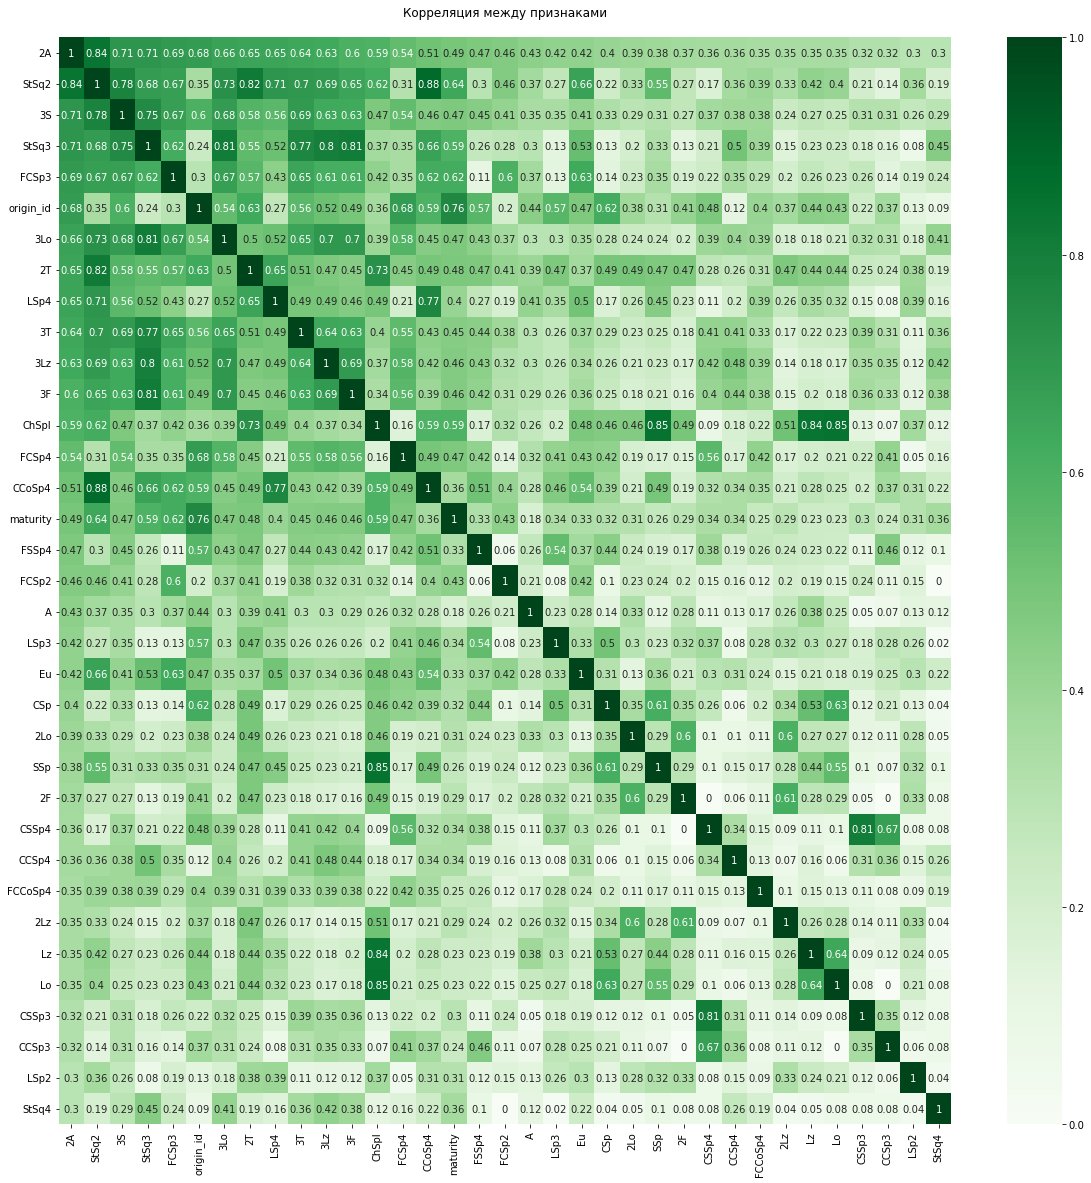

In [116]:
plt.figure(figsize = (20, 20))
plt.title('Корреляция между признаками\n');
sns.heatmap(round(abs(sig_corr_matrix), 2), 
            annot = True,
           cmap = 'Greens');
plt.show()

- наблюдается **сильная и средняя корреляция между практически всеми признаками** 
- наблюдается сильная мультиколлинеарность между некоторыми признаками, но поскольку возможно, будет стоять задача предсказания какого-то из мультиколлинеарных признаков, все мультиколлинеарные признаки оставлены в выборке

## Подготовим данные для машинного обучения

### Выделим вектор целевого признака `target` и создадим матрицу признаков 

- Для примера создадим модель, которая будет предсказывать **вероятность успеха** тройных прыжков

In [117]:
jumps = ['3A', '3F', '3Lo', '3Lz', '3S', '3T']

In [118]:
target = unit_program_success_elements[jumps]
features = unit_program_success_elements.drop(jumps, axis = 1)

In [119]:
display(features.shape)
target.shape

(3392, 54)

(3392, 6)

- из исходного датасета `data` выделен массив признаков `features` и вектор **целевого признака** `target`

### Разделим выборку на обучающую и тестовую

#### Выделим из массива признаков **обучающую** и **тестовую** выборки

In [120]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                            random_state = RANDOM_STATE,
                            shuffle = True,
                            test_size = TEST_SIZE,
                                                                           )

In [121]:
display(features_train.shape,
        round(features_train.shape[0]/features.shape[0], 2),
        features_test.shape,
        round(features_test.shape[0]/features.shape[0], 2))
display(target_train.shape, target_test.shape)

(2544, 54)

0.75

(848, 54)

0.25

(2544, 6)

(848, 6)

In [122]:
target_train.head()

,3A,3F,3Lo,3Lz,3S,3T
171,0.0,0.000000,0.0,0.0,0.0,0.000000
1853,0.0,0.000000,0.0,0.0,0.0,0.000000
506,0.0,0.833333,0.0,1.0,0.4,0.857143
2962,0.0,0.000000,0.0,0.0,0.0,0.000000
3241,0.0,0.000000,0.0,0.0,0.0,0.000000


- из датасета выделены **обучающая** и **тестовая** выборки в пропорции 75% и 25%

## Обучим и протестируем модели методом кросс-валидации

#### Определим функции, обрабатывающие и создающие признаки, балансирующие классы, а также заполняющие пропуски

In [123]:
constant_imputer = SimpleImputer(strategy='constant', fill_value = 0)

### Обучим с применением метода кросс-валидации модель `KNeighborsRegressor`

#### Зададим неизменяемые гиперпараметры модели

In [124]:
knr = KNeighborsRegressor(n_jobs = -1)

#### Сконструируем конвейер для обучения модели

In [125]:
knr_pipe = Pipeline(steps=[
    ("constant_imputer", constant_imputer),
    ("knr", knr)])
print(knr_pipe)

Pipeline(steps=[('constant_imputer',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('knr', KNeighborsRegressor(n_jobs=-1))])


#### Зададим диапазоны гиперпараметров для поиска оптимальной метрики `MSE` методом `кросс-валидации`

**- Поиск проводился в следующем диапазоне на 500 шагах:**

    - 'knr__weights': CategoricalDistribution(['uniform', 'distance']),
    - 'knr__algorithm': CategoricalDistribution(['auto', 'ball_tree', 'kd_tree', 'brute']),
    - 'knr__n_neighbors': IntDistribution(1, 50),
    - 'knr__leaf_size': IntDistribution(1, 100),
    - 'knr__p': FloatDistribution(1, 50)

In [126]:
# Лучшее значение метрики MSE = 0.06 найдено при следующих гиперпараметрах
knr_param_distrs = {
    'knr__weights': CategoricalDistribution(['distance']),
    'knr__algorithm': CategoricalDistribution(['brute']),
    'knr__n_neighbors': IntDistribution(8, 8),
    'knr__leaf_size': IntDistribution(17, 17),
    'knr__p': FloatDistribution(1.0010251227093974, 1.0010251227093974),
                      }

#### Объявим функцию `OptunaSearchCV` для поиска оптимальных гиперпараметров

In [127]:
knr_opt_search = OptunaSearchCV(
    knr_pipe, 
    knr_param_distrs,
    cv = 5, 
    n_trials=1,
    scoring='neg_mean_squared_error',
    random_state = RANDOM_STATE
                                )


/tmp/ipykernel_371454/3430571972.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  knr_opt_search = OptunaSearchCV(


#### Проведем поиск оптимальных гиперпараметров

In [128]:
knr_opt_search.fit(features_train, target_train)

[I 2024-05-31 23:22:00,589] A new study created in memory with name: no-name-c6e9d50c-2fd6-469f-8b15-2e7e6ecea5c2
[I 2024-05-31 23:22:01,590] Trial 0 finished with value: -0.05894345599228655 and parameters: {'knr__weights': 'distance', 'knr__algorithm': 'brute', 'knr__n_neighbors': 8, 'knr__leaf_size': 17, 'knr__p': 1.0010251227093974}. Best is trial 0 with value: -0.05894345599228655.


OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('constant_imputer',
                                          SimpleImputer(fill_value=0,
                                                        strategy='constant')),
                                         ('knr',
                                          KNeighborsRegressor(n_jobs=-1))]),
               n_jobs=1, n_trials=1,
               param_distributions={'knr__algorithm': CategoricalDistribution(choices=('brute',)),
                                    'knr__leaf_size': IntDistribution(high=17, log=False, low=17, step=1),
                                    'knr__n_neighbors': IntDistribution(high=8, log=False, low=8, step=1),
                                    'knr__p': FloatDistribution(high=1.0010251227093974, log=False, low=1.0010251227093974, step=None),
                                    'knr__weights': CategoricalDistribution(choices=('distance',))},
               random_state=53, scoring='neg_mean_squared_error')

In [129]:
print("\nЛучшее полученное методом кросс-валидации \n\
значение метрики MSE: %0.2f" % (-knr_opt_search.best_score_),
"найдено при следующих гиперпараметрах\n")
print(knr_opt_search.best_params_)


Лучшее полученное методом кросс-валидации 
значение метрики MSE: 0.06 найдено при следующих гиперпараметрах

{'knr__weights': 'distance', 'knr__algorithm': 'brute', 'knr__n_neighbors': 8, 'knr__leaf_size': 17, 'knr__p': 1.0010251227093974}


### Обучим c применением метода `кросс-валидации` модель `RandomForestRegressor`  

#### Объявим функцию `feature_creator` для обработки и создания новых признаков

#### Зададим неизменяемые гиперпараметры модели

In [130]:
rfc = RandomForestRegressor(
                       n_jobs=-1,
                       random_state=RANDOM_STATE, 
                       verbose=0,
                       )

#### Сконструируем конвейер для предобработки данных и обучения модели

In [131]:
rfc_pipe = Pipeline(steps=[
    ("constant_imputer", constant_imputer),
    ("rfc", rfc)])
print(rfc_pipe)

Pipeline(steps=[('constant_imputer',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('rfc', RandomForestRegressor(n_jobs=-1, random_state=53))])


#### Зададим диапазоны гиперпараметров для поиска оптимальной метрики `MSE` методом `кросс-валидации`

**- Подбор гиперпараметров осуществлялся в следующих диапазонах на 500 шагах:**

    - 'rfc__n_estimators': IntDistribution(1, 500),
    - 'rfc__max_depth': IntDistribution(1, 500),
    - 'rfc__min_samples_leaf': IntDistribution(1, 300),
    - 'rfc__min_samples_split': IntDistribution(2, 300),
                      }

In [132]:
# Лучшее найденное значение метрики MSE = 0.04
rfc_param_distrs = {
    'rfc__n_estimators': IntDistribution(127, 127),
    'rfc__max_depth': IntDistribution(430, 430),
    'rfc__min_samples_leaf': IntDistribution(8, 8),
    'rfc__min_samples_split': IntDistribution(20, 20),
                      }

#### Объявим функцию поиска оптимальных гиперпараметров

In [133]:
rfc_opt_search = OptunaSearchCV(
    rfc_pipe, 
    rfc_param_distrs,
    cv = 5, 
    n_trials=1,
    scoring='neg_mean_squared_error',
    random_state = RANDOM_STATE,
)


/tmp/ipykernel_371454/191026743.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  rfc_opt_search = OptunaSearchCV(


#### Проведем поиск оптимальных гиперпараметров

In [134]:
rfc_opt_search.fit(features_train, target_train)

[I 2024-05-31 23:22:01,649] A new study created in memory with name: no-name-4e73e5b3-e434-446c-b781-602fc4075363
[I 2024-05-31 23:22:03,019] Trial 0 finished with value: -0.04026304890785885 and parameters: {'rfc__n_estimators': 127, 'rfc__max_depth': 430, 'rfc__min_samples_leaf': 8, 'rfc__min_samples_split': 20}. Best is trial 0 with value: -0.04026304890785885.


OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('constant_imputer',
                                          SimpleImputer(fill_value=0,
                                                        strategy='constant')),
                                         ('rfc',
                                          RandomForestRegressor(n_jobs=-1,
                                                                random_state=53))]),
               n_jobs=1, n_trials=1,
               param_distributions={'rfc__max_depth': IntDistribution(high=430, log=False, low=430, step=1),
                                    'rfc__min_samples_leaf': IntDistribution(high=8, log=False, low=8, step=1),
                                    'rfc__min_samples_split': IntDistribution(high=20, log=False, low=20, step=1),
                                    'rfc__n_estimators': IntDistribution(high=127, log=False, low=127, step=1)},
               random_state=53, scoring='neg_mean_squared_error')

In [135]:
print("\nЛучшее полученное методом кросс-валидации \n \
значение метрики MSE = %0.2f:" % - rfc_opt_search.best_score_,
"найдено при следующих параметрах")
print(rfc_opt_search.best_params_)


Лучшее полученное методом кросс-валидации 
 значение метрики MSE = 0.04: найдено при следующих параметрах
{'rfc__n_estimators': 127, 'rfc__max_depth': 430, 'rfc__min_samples_leaf': 8, 'rfc__min_samples_split': 20}


### Изучим важность признаков для лучшей модели

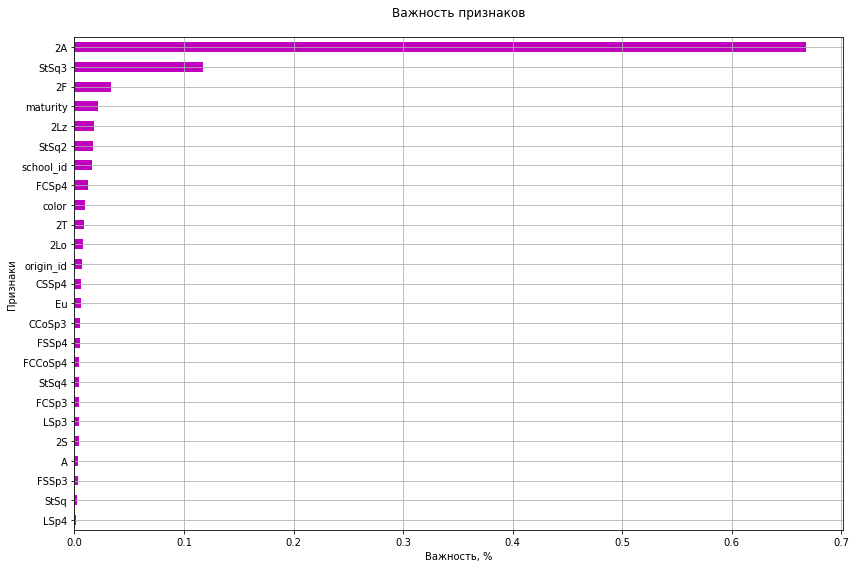

In [136]:
rfc_imp = pd.Series(
    rfc_opt_search.best_estimator_[-1].feature_importances_,
    index = features_train.columns
).sort_values(ascending = False).head(25)
fig, ax = plt.subplots(figsize=(12, 8))
rfc_imp.sort_values(ascending = True).plot.barh(ax=ax, color = 'm')
ax.set_title("Важность признаков\n")
ax.set_xlabel('Важность, %')
ax.set_ylabel('Признаки')
fig.tight_layout()
ax.grid(True)

In [137]:
important_features = rfc_imp.sort_values(ascending = False).head(10)
display(important_features)
important_features = important_features.index

2A           0.668106
StSq3        0.116918
2F           0.033329
maturity     0.021280
2Lz          0.018003
StSq2        0.016485
school_id    0.015827
FCSp4        0.011943
color        0.009971
2T           0.009036
dtype: float64

 - анализ важности признаков для модели `RandomForestRegressor` показывает, что самый важный признак это двойной аксель - `2A`, за ним идут признаки `StSq3`, `2F`, признак длительности выступлений `maturity`. Также в десятку самых важных признаков попали признаки `school_id` и `color`

### Выводы по результатам обучения и тестирования моделей 

- лучшее полученное методом кросс-валидации значение метрики `MSE` модели `RandomForestRegressor` = **0.04**, лучше метрики модели `KNeighborsRegressor` (**0.06**)
- для дальнейшего тестирования выбирается модель `RandomForestRegressor`

## Протестируем модель `RandomForestRegressor` на выделенной тестовой выборке

### Обучим модель на тестовой выборке

In [138]:
rfc_opt_search.best_estimator_.fit(
    features_train, target_train)

rfc_predictions_test = rfc_opt_search.best_estimator_.predict(
    features_test)

### Сравним метрики модели, полученные в процессе обучения с кросс-валидацией, и метрики на тестовой выборке

In [139]:
rfc_cv_score = cross_validate(rfc_opt_search.best_estimator_, 
                features_train, target_train, 
                scoring=('r2', 'neg_mean_absolute_error'), 
                cv=5, 
                verbose=0)
r2_train_cv_score = rfc_cv_score['test_r2'].mean()
mae_train_cv_score = rfc_cv_score['test_neg_mean_absolute_error'].mean()

In [140]:
rfc_r2_test_score = r2_score(target_test, rfc_predictions_test)
rfc_test_mae = mean_absolute_error(target_test, rfc_predictions_test)
rfc_test_mse = mean_squared_error(target_test, rfc_predictions_test)

In [141]:
print('R2 train', r2_train_cv_score)
print('R2 test', rfc_r2_test_score)
print()
print('MAE train', - mae_train_cv_score)
print('MAE test', rfc_test_mae)
print()
print('RMSE train', (- rfc_opt_search.best_score_)**0.5)
print('RMSE test', rfc_test_mse **0.5)

R2 train 0.5630079438213047
R2 test 0.5435343839212807

MAE train 0.0993999060994112
MAE test 0.09131520414951473

RMSE train 0.20065654464247823
RMSE test 0.19364999763180135


**По результатам исследования метрик модели `RandomForestRegressor` можно сделать следующие выводы:**
- метрика `R2` больше **0.5**, модель **адекватна** и имеет удовлетворительное качество
- значения метрики среднего абсолютной ошибки `MAE` и на обучающей и на тестовой выборке не превышает **0.1** (оцениваются вероятности успешного выполнения элемента), при этом значения метрики корня из средней квадратичной ошибки `RMSE` не превышают **0.2**, что позволяет говорить о достаточно точном прогнозировании вероятности успеха исполнения элемента
- значения всех метрик, полученных на обучающей и тестовой выборках, близки, что говорит о **стабильности** модели

- **Модель `RandomForestRegressor` c гиперпараметрами:**
    - `n_estimators`: **127**, 
    - `max_depth`: **430**, 
    - `min_samples_leaf`: **8**,
    - `min_samples_split`: **20**
    
**может быть рекомендована** для предсказания **вероятности успешного выполнения тройных прыжков**

## Отчет

### Задача

- Сервис  **Мой Чемпион** помогает спортивным школам фигурного катания и тренерам мониторить результаты своих подопечных и планировать дальнейшее развитие спортсменов.

**Цель**
- Создать модель, помогающую находить элементы, которые могут быть успешно исполнены спортсменом на соревновании, прогноз нужно делать для спортсменов - одиночников

**Задача**
- Поскольку выявлена невозможность выделения стоимости каждого элемента из общей стоимости последовательности элементов, принято решение нахождения **вероятности успешного исполнения каждого элемента**. 
- Задача решена **частично** - модель предсказывает только **вероятности исполнения тройных прыжков**
- Для получения предсказаний по **другим группам** элементов необходимо создать дополнительные модели, аналогичные имеющейся на базе того-же датасета, но с другим набором **целевых признаков**

### Предварительная обработка данных

- На базе датасета `tournament_scores` создан сводный датасет `data`, содержащий информацию всех имеющихся датасетов, объединенных по ключам

- из датасета выделены все элементы, исполненные за наблюдаемый период спортсменами, в том числе в последовательностях, и посчитаны по каждому спортсмену:
    - количество выполненных элементов,
    - количество успешно выполненных элементов, 
    - и на базе этих данных посчитана **вероятность успешного выполнения каждым спортсменом конкретного элемента**, как **отношение успешно выполненных** элементов каждого вида к **количеству выполненных элементов каждого вида**

- удалены данные о датах соревнований и оценках, текстовые признаки, а также данные об ошибках

- удалены признаки, в которых экстремально мало значений, поскольку они бесполезны для обучения и по ним невозможно сделать предсказание

- в результате **создан** `обучающий датасет`, в котором в виде признаков указаны `вероятности успешного исполнения каждого элемента`, а также признаки `школы`, `пола`, `времени выступлений` и `страны`

### Исследовательский анализ данных

- наблюдается **сильная и средняя корреляция между практически всеми признаками** 
- наблюдается сильная мультиколлинеарность между некоторыми признаками, но поскольку возможно, будет стоять задача предсказания какого-то из мультиколлинеарных признаков, все мультиколлинеарные признаки оставлены в выборке

### Обучение моделей

- для обучения и сравения были выбраны две модели, использующие разные принципы принятия решений: `KNeighborsRegressor` и `RandomForestRegressor`

- лучшее полученное методом кросс-валидации значение метрики `MSE` модели `RandomForestRegressor` = **0.04**, что лучше метрики модели `KNeighborsRegressor` (**0.05**)
- для дальнейшего тестирования выбрана модель `RandomForestRegressor`

**По результатам тестирования модели `RandomForestRegressor` на тестовой выборке** и в результате сравнения метрик, полученных на тестовой и обучающей выборках, можно сделать следующие выводы:
- метрика `R2` модели больше **0.5**, модель **адекватна** и имеет **среднее** качество предсказаний
- значения метрики среднего абсолютной ошибки `MAE` и на обучающей и на тестовой выборке не превышает **0.1** (оцениваются вероятности успешного выполнения элемента), при этом значения метрики корня из средней квадратичной ошибки `RMSE` не превышают **0.2**, что позволяет говорить о достаточно точном прогнозировании вероятности успеха исполнения элемента
- значения всех метрик, полученных на обучающей и тестовой выборках, **близки**, что говорит о **стабильности** модели

## Выводы

- **Модель `RandomForestRegressor` c гиперпараметрами:**
    - `n_estimators`: **127**, 
    - `max_depth`: **430**, 
    - `min_samples_leaf`: **8**,
    - `min_samples_split`: **20**
    
**может быть рекомендована** для предсказания **вероятности успешного выполнения тройных прыжков**

## Предложения по улучшению точности прогнозирования

- нужно делать отдельную модель для **каждого** признака, в этом случае качество модели по метрике `R2` может для некоторых элементов быть улучшено до **0.8** (например для `2A`)

- необходимо отметить, что для прогнозирования целого ряда сложных элементов, например четверных прыжков, в выборке слишком мало данных, прогноз имеет крайне низкое качество, нужно обогащать выборку новыми данными